# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [9]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")


#conf.set("spark.executor.memory", "2g")

# CHANGE
conf.set("spark.executor.memory", "6g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")
conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "4")  # сколько ядер у каждого

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

In [8]:
sc.stop()

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [10]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-17 12:08 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-17 12:08 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-17 12:08 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-17 12:08 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-17 12:08 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-17 12:08 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-17 12:08 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-17 12:08 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-17 12:08 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [11]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [12]:
ratings = sc.textFile(RATINGS_PATH)

In [13]:
%%time
ratings.take(5)

CPU times: user 19 ms, sys: 2.01 ms, total: 21 ms
Wall time: 3.32 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [14]:
ratings.getNumPartitions()

5

In [15]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [16]:
ratings.count()

25000095

Количество пользователей

In [11]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 19.5 ms, sys: 10.3 ms, total: 29.8 ms
Wall time: 57.4 s


162541

Сохраним датасет в память

In [17]:
ratings = ratings.persist()

In [18]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 75.1 ms, sys: 16.9 ms, total: 92 ms
Wall time: 1min 52s


162541

Количество фильмов

In [19]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 39.5 ms, sys: 11.9 ms, total: 51.4 ms
Wall time: 37.9 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [20]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [21]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [22]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [23]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-17 12:18 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2021-02-17 12:18 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2021-02-17 12:18 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2021-02-17 12:18 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2021-02-17 12:18 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2021-02-17 12:18 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2021-02-17 12:18 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2021-02-17 12:18 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2021-02-17 12:18 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2021-02-17 12:18 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [24]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [25]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [26]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

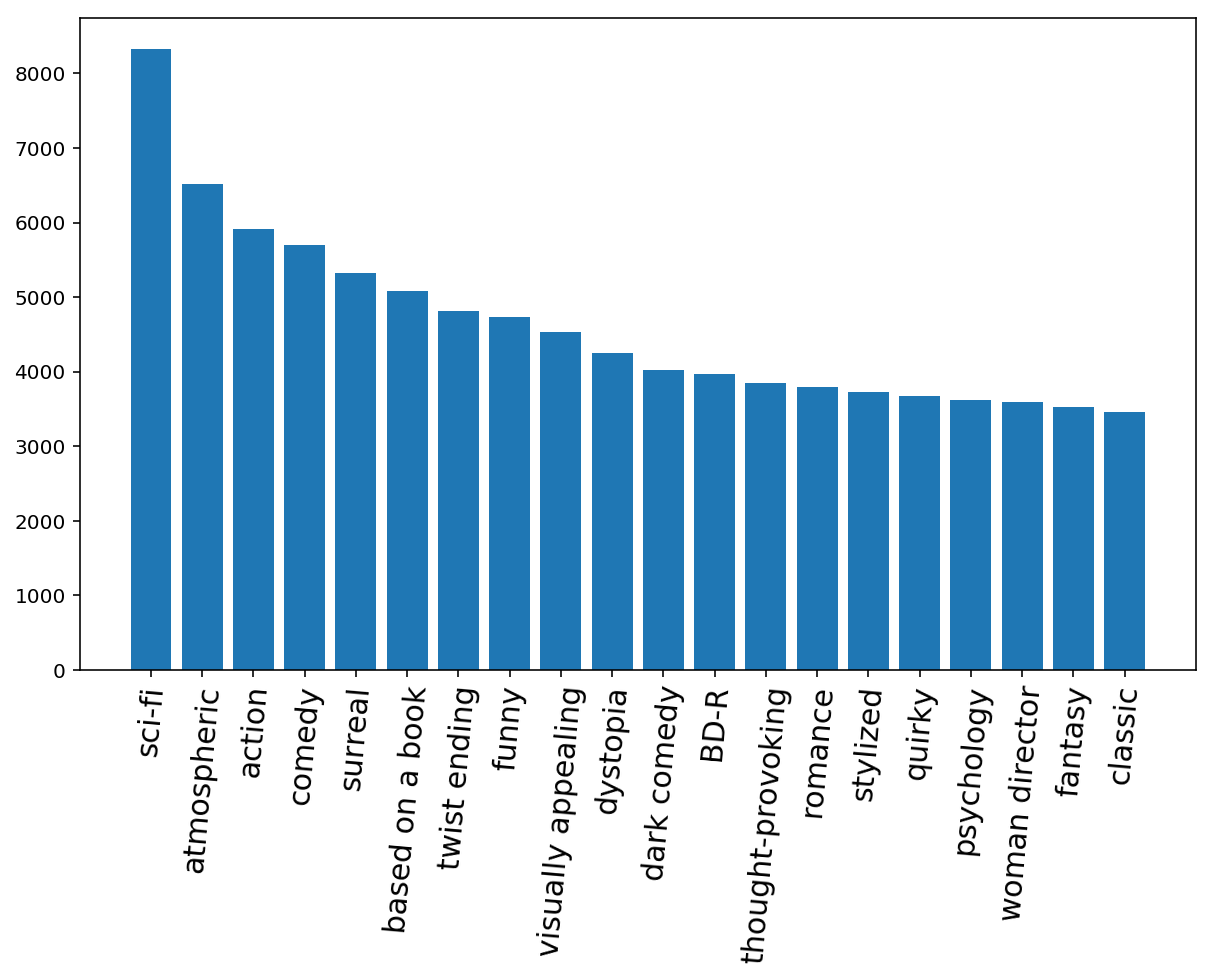

In [27]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [34]:
######################################
######### YOUR CODE HERE #############
######################################
N_MOVIES = 10


ratings \
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .join(movies)\
    .sortBy(lambda m: m[1], ascending=False)\
    .map(lambda row: (row[1][1][1], row[1][0]))\
    .take(N_MOVIES)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [35]:
######################################
######### YOUR CODE HERE #############
######################################
N_MOVIES = 10
REQUIRED_RATING = 5.0


ratings \
    .filter(lambda r: r.rating == REQUIRED_RATING)\
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .join(movies)\
    .sortBy(lambda m: m[1], ascending=False)\
    .map(lambda row: (row[1][1][1], row[1][0]))\
    .take(N_MOVIES)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

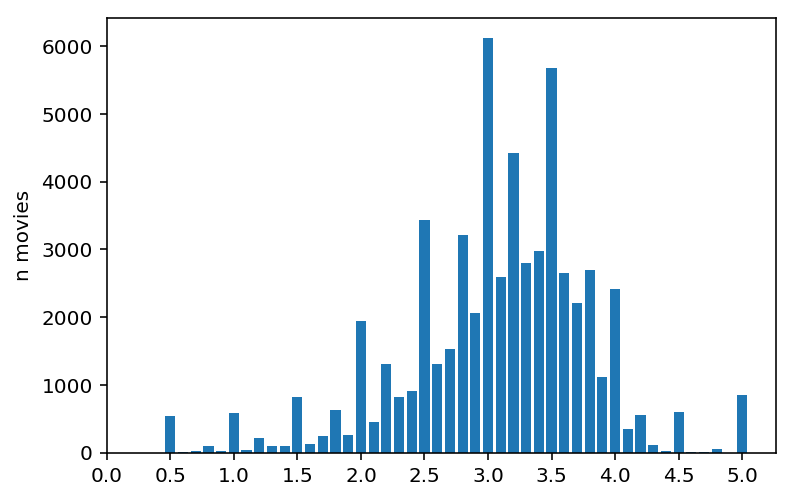

In [102]:
######################################
######### YOUR CODE HERE #############
######################################

# multiply by 10 and round somehow (round or int)
# OR .map(lambda row: (int(10 * row[1]), 1))

query = movie_avg_rating\
    .map(lambda r: (round(10 * r[1]), 1))\
    .reduceByKey(lambda x, y: x + y)\
    .map(lambda r: (r[0], r[1]))


tiks = [5*k for k in range(10 + 1)]
plt.bar(*zip(*query.collect()))
plt.xticks(tiks, map(lambda x: str(x/10), tiks))
plt.ylabel("n movies")
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

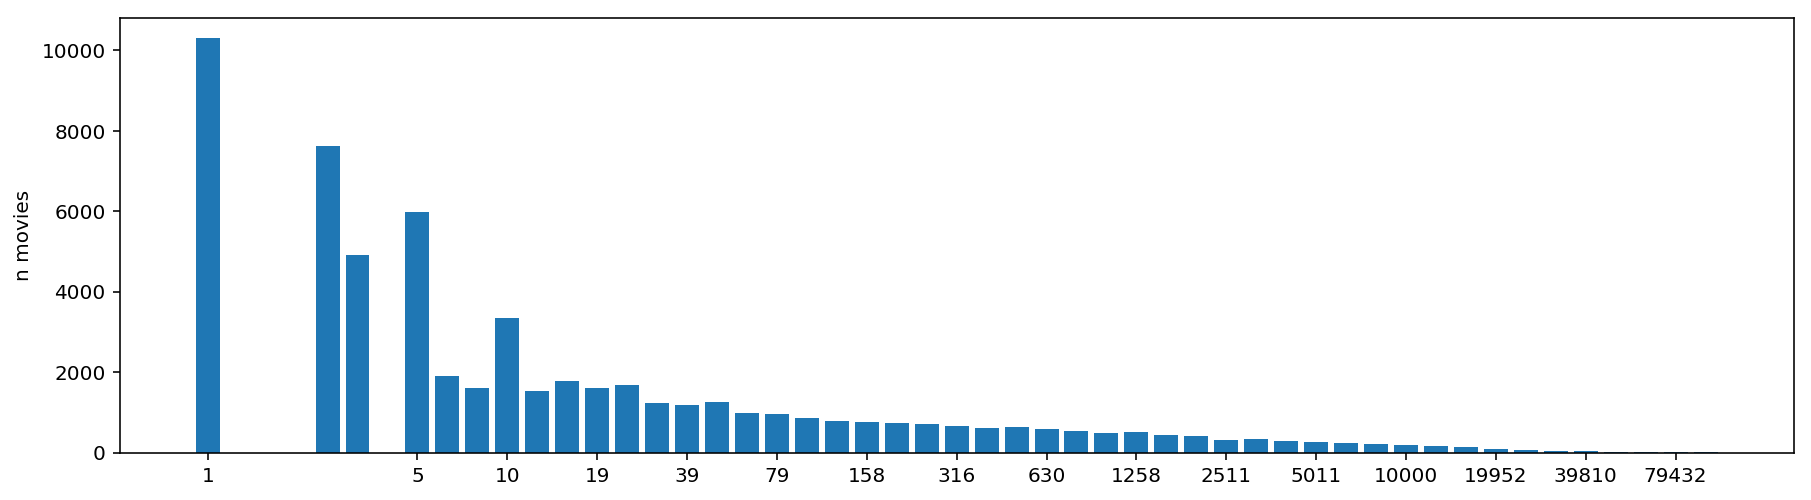

In [125]:
######################################
######### YOUR CODE HERE #############
######################################
import math


def bucket_func(r):
    return math.ceil(10 * np.log10(r))


query = ratings \
    .map(lambda row: (row.movie_id, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .map(lambda row: (bucket_func(row[1]), 1))\
    .reduceByKey(lambda x, y: x + y)


k, v = zip(*query.collect())
tiks = list(sorted(k))[::3]
f, ax = plt.subplots(figsize=(15, 4))
plt.bar(k, v)
plt.xticks(tiks, map(lambda x: str(int(10**(x/10))), tiks))
plt.ylabel("n movies")
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

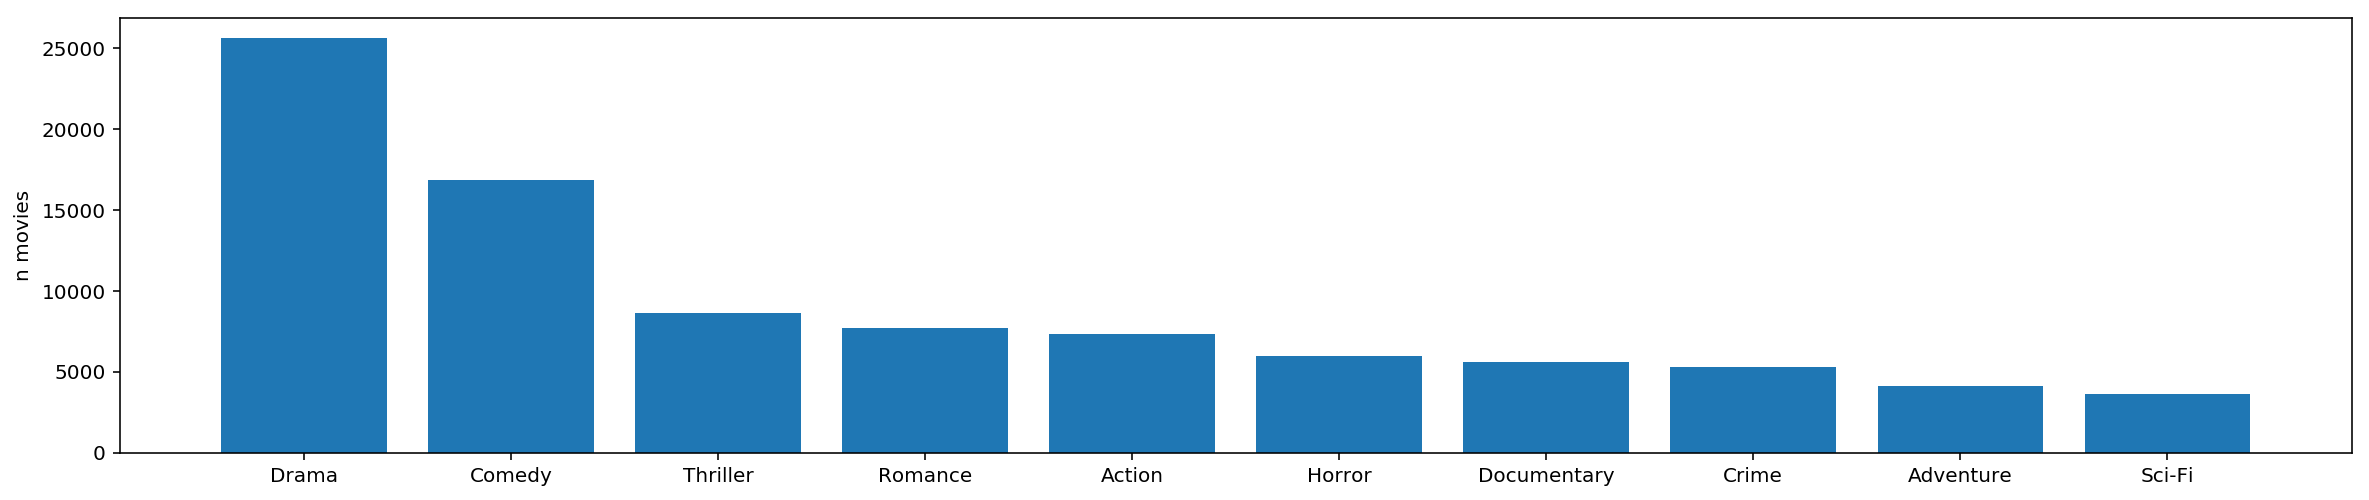

In [227]:
######################################
######### YOUR CODE HERE #############
######################################
N_GENRES = 10


def get_genres(row):
    mov_id, *_, genres = row.split(',')
    return (mov_id, genres)


def filter_genre(row):
    mov_id, genres = row
    return mov_id.isdigit() and len(set(row[1]) & set("()")) == 0


# rebuild movies
movies = sc.textFile(MOVIES_PATH)

# extract genres
genres =  movies\
    .map(lambda row: get_genres(row))\
    .filter(lambda row: filter_genre(row))\
    .keyBy(lambda row: int(row[0]))\
    .map(lambda row: (row[0], row[1][1].split('|')))

# make query
query = genres \
    .flatMap(lambda row: row[1])\
    .map(lambda row: (row, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .sortBy(lambda m: m[1], ascending=False)


f, ax = plt.subplots(figsize=(20, 4))
X, Y = zip(*query.collect()[:N_GENRES])
genres10 = X
plt.bar(X, Y)
plt.ylabel("n movies")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [216]:
######################################
######### YOUR CODE HERE #############
######################################
import json

TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [218]:
# build tmdb
tmdb = sc.textFile(TMDB_PATH)\
    .map(lambda s: json.loads(s))\
    .filter(lambda row: 'title' in row)\
    .keyBy(lambda row: int(row['id']))


actordb = tmdb \
    .flatMapValues(lambda row: row['casts']['cast'])\
    .keyBy(lambda row: int(row[1]['id']))


actordb.take(1)[0][1]

(862,
 {'cast_id': 14,
  'character': 'Woody (voice)',
  'credit_id': '52fe4284c3a36847f8024f95',
  'gender': 2,
  'id': 31,
  'name': 'Tom Hanks',
  'order': 0,
  'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'})

In [219]:
### 1 TASK  ###
ACTOR_ID = 31


# join by id -> title
hanks_movies = actordb \
    .filter(lambda row: int(row[0]) == ACTOR_ID)\
    .map(lambda row: row[1][0])\
    .keyBy(lambda row: row)\
    .join(tmdb.mapValues(lambda row: row['title']))\
    .map(lambda row: row[1][1])\
    .collect()

hanks_movies[:5]

['The Terminal',
 'Sleepless in Seattle',
 'Big',
 'California Typewriter',
 'Cast Away']

In [220]:
### 2 TASK  ###
N_ACTORS = 10


# join by id -> actor
actor_records \
    .mapValues(lambda row: 1)\
    .reduceByKey(lambda a, b: a + b)\
    .join(actor_records.mapValues(lambda row: row[1]['name']).distinct())\
    .sortBy(lambda k: k[1][0], ascending=False)\
    .map(lambda row: (row[1][1], row[1][0]))\
    .take(N_ACTORS)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 130)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [315]:
######################################
######### YOUR CODE HERE #############
######################################
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')

In [349]:
def mov2tmdb(row):
    mov_id, _, tmdb_id = row.split(',')
    return (mov_id, tmdb_id)


# build links
links = sc.textFile(LINKS_PATH)\
    .map(lambda row: mov2tmdb(row))\
    .filter(lambda row: row[0] != 'movieId')\
    .keyBy(lambda row: int(row[0]))\
    .map(lambda row: (row[0], row[1][1]))

links.take(5)

[(1, '862'), (2, '8844'), (3, '15602'), (4, '31357'), (5, '11862')]

In [362]:
def filter_genrestmdb(row):
    return row[1][1]

genrestmdb = genres\
    .join(links)\
    .filter(lambda row: filter_genrestmdb(row))\
    .map(lambda r: (int(r[1][1]), r[1][0][0]))

In [ ]:
# ...

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

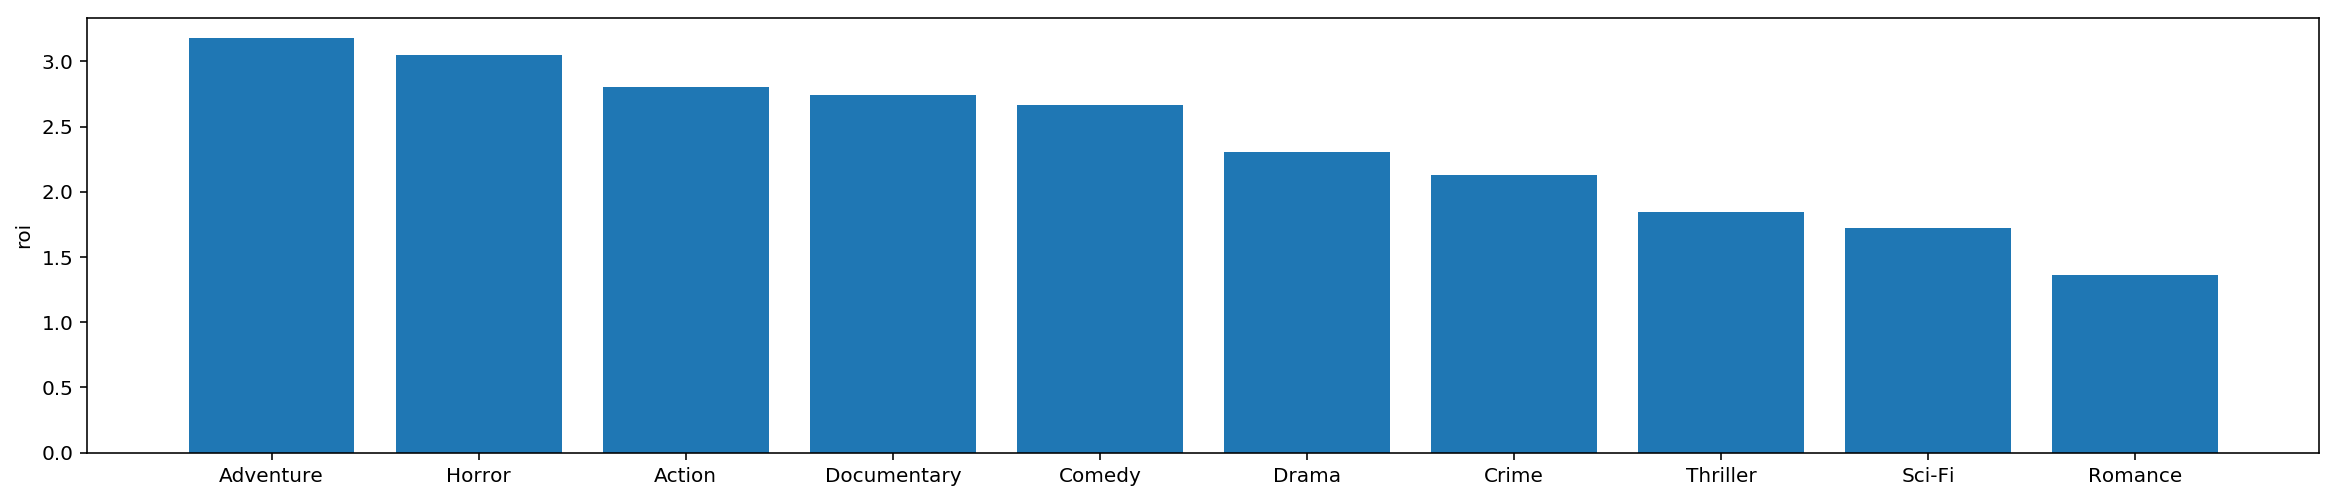

In [363]:
######################################
######### YOUR CODE HERE #############
######################################

def filter_revbud(row):
    _, info = row
    rev, bud = info
    return rev > 0 and bud > 0


# build revbud ds, filter out
revbud = tmdb\
    .mapValues(lambda row: (row["revenue"], row["budget"]))\
    .filter(lambda row: filter_revbud(row))


# make query
query = genrestmdb \
    .filter(lambda r: r[1] in genres10)\
    .join(revbud)\
    .map(lambda r: r[1])\
    .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))\
    .mapValues(lambda r: r[0] / r[1])\
    .sortBy(lambda x: x[1], ascending=False)\
    .collect()


f, ax = plt.subplots(figsize=(20, 4))
plt.bar(*zip(*genre_roi[:len(genres10)]))
plt.ylabel("roi")
plt.show()